In [ ]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

import grand.dataio.root_trees as rt

import database.tools as tools

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

tools.load_logger('debug')

Welcome to JupyROOT 6.30/04


<Logger database.v2.tools (DEBUG)>

In [2]:
RUN     = 10086
MODE    = 'CD'
TH1     = 45
TH2     = 35
TQUIET  = 500
TPER    = 1000
TSEPMAX = 200
NCMIN   = 2#1
NCMAX   = 10#7

CHANNELS_FLT0_STR = 'XY'
MODE_FLT0         = 'OR'

N_SAMPLES  = 1024
N_CHANNELS = 3

PLOT_TITLE = f'T1 = {TH1}, T2 = {TH2}, TQUIET = {TQUIET}, TPER = {TPER}, TSEPMAX = {TSEPMAX}, NCMIN = {NCMIN}, NCMAX = {NCMAX}'
PLOT_SUPTITLE = f'{MODE}, run {RUN}, {CHANNELS_FLT0_STR} mode {MODE_FLT0}'

PLOT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
database_dir    = '/sps/grand/pcorrea/nutrig/database/v2/bkg'
database_subdir = os.path.join(database_dir,f'GP80_RUN_{RUN}_CH_{CHANNELS_FLT0_STR}_MODE_{MODE_FLT0}_TH1_{TH1}_TH2_{TH2}_TQUIET_{TQUIET}_TPER_{TPER}_TSEPMAX_{TSEPMAX}_NCMIN_{NCMIN}_NCMAX_{NCMAX}')

path_metadata_file = os.path.join(database_subdir,'metadata.npz')

database_subdir_filtered = os.path.join(database_subdir,'filtered')
database_subdir_raw      = os.path.join(database_subdir,'raw')

paths_data_files_filtered = sorted( glob.glob( os.path.join(database_subdir_filtered,'*.npz') ) )
paths_data_files_raw      = sorted( glob.glob( os.path.join(database_subdir_raw,'*.npz') ) )

In [4]:
with np.load(path_metadata_file,allow_pickle=True) as metadata_file:
    for key in metadata_file.keys():
        print(f'{key} : {metadata_file[key]}')
    t_eff = metadata_file['t_eff']
    channel_pol = metadata_file['channel_pol'].item()
    channels_flt0 = metadata_file['channels_flt0']
    samples_from_edge = metadata_file['samples_from_edge']

dict_trigger_params : {'th1': 45, 'th2': 35, 't_quiet': 500, 't_period': 1000, 't_sepmax': 200, 'nc_min': 2, 'nc_max': 10}
root_data_dir : /sps/grand/data/gp80/GrandRoot/2025/05
run_number : 10086
du_ids_exclude : [1047 1049 1054 1055 1082 1086]
samples_from_edge : 100
t_eff : -1
channel_pol : {0: 'X', 1: 'Y', 2: 'Z'}
channels_flt0 : [0 1]
mode_flt0 : OR


In [5]:
path_test_file = paths_data_files_filtered[0]
with np.load(path_test_file) as test_file:
    for key in test_file.keys():
        print(f'{key}')

traces
du_ids
du_seconds
du_nanoseconds
FLT0_flags
FLT0_first_T1_idcs
n_FLT0
trigger_rate_per_ch
trigger_rate_OR
trigger_rate_AND
t_bin_trigger_rate


In [6]:
traces_filtered     = np.zeros((0,N_CHANNELS,N_SAMPLES))
du_ids              = np.zeros((0,),dtype=int)
du_seconds          = np.zeros((0,),dtype=int)
FLT0_flags          = np.zeros((0,N_CHANNELS), dtype=bool)
FLT0_first_T1_idcs  = np.zeros((0,N_CHANNELS), dtype=int)
n_FLT0              = np.zeros((0,N_CHANNELS), dtype=int)

for path_data_file_filtered in paths_data_files_filtered[:]:
    with np.load(path_data_file_filtered) as data_file_filtered:
        traces_filtered     = np.vstack( ( traces_filtered,data_file_filtered['traces'] ) )
        du_ids              = np.hstack( ( du_ids,data_file_filtered['du_ids'] ) )
        du_seconds          = np.hstack( ( du_seconds,data_file_filtered['du_seconds'] ) )
        FLT0_flags          = np.vstack( ( FLT0_flags,data_file_filtered['FLT0_flags'] ) )
        FLT0_first_T1_idcs  = np.vstack( ( FLT0_first_T1_idcs,data_file_filtered['FLT0_first_T1_idcs'] ) )
        n_FLT0              = np.vstack( ( n_FLT0,data_file_filtered['n_FLT0'] ) )

In [7]:
traces_raw = np.zeros((0,N_CHANNELS,N_SAMPLES))

for path_data_file_raw in paths_data_files_raw[:]:
    with np.load(path_data_file_raw) as data_file_raw:
        traces_raw = np.vstack( ( traces_raw,data_file_raw['traces'] ) )

## Check FLT-0 rates

In [63]:
# Assume no DUs have dropped out over the entire run

du_ids_unique = np.unique(du_ids)
n_du          = len(du_ids_unique)

trigger_rate_per_ch = np.zeros((n_du,0,N_CHANNELS), dtype=int)
trigger_rate_OR     = np.zeros((n_du,0), dtype=int)
trigger_rate_AND    = np.zeros((n_du,0), dtype=int)
t_bin_trigger_rate  = np.zeros((n_du,0), dtype=int)

for path_data_file_filtered in paths_data_files_filtered[:]:
    with np.load(path_data_file_filtered) as data_file_filtered:
        #print(data_file_filtered['trigger_rate_per_ch'].shape)
        trigger_rate_per_ch = np.concatenate( ( trigger_rate_per_ch, np.expand_dims( data_file_filtered['trigger_rate_per_ch'],axis=1 ) ),axis=1 )
        trigger_rate_OR     = np.concatenate( ( trigger_rate_OR, np.expand_dims( data_file_filtered['trigger_rate_OR'],axis=1 ) ),axis=1 )
        trigger_rate_AND    = np.concatenate( ( trigger_rate_AND, np.expand_dims( data_file_filtered['trigger_rate_AND'],axis=1 ) ),axis=1 )
        t_bin_trigger_rate  = np.concatenate( ( t_bin_trigger_rate, np.expand_dims( data_file_filtered['t_bin_trigger_rate'],axis=1 ) ),axis=1 )

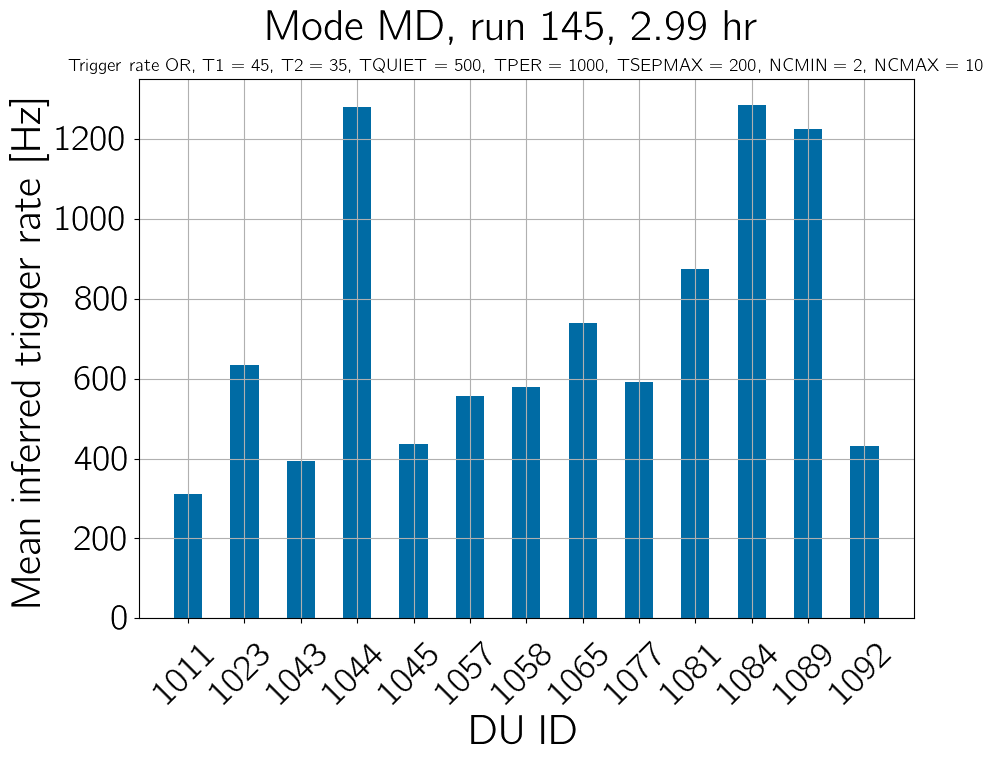

In [64]:
time_full_run  = ( du_seconds[-1] - du_seconds[0] ) # [s]
N_tot_full_run = time_full_run * 20 # assuming 20 Hz and 100% efficiency for all DUs

N_trig = np.zeros(du_ids_unique.shape,dtype=int)

for i, du in enumerate(du_ids_unique):
    N_trig[i] = len(np.where(du_ids==du)[0])

rates_full_run = N_trig / (N_tot_full_run*t_eff*1e-9) # [Hz]


fig, ax = plt.subplots()

x     = np.arange(len(du_ids_unique))  # the label locations
width = 0.5                    # the width of the bars

ax.bar(x, rates_full_run, width)

ax.set_xticks(x)  # Center the ticks between the groups
ax.set_xticklabels(du_ids_unique,rotation=45)

ax.set_xlabel('DU ID')
ax.set_ylabel('Mean inferred trigger rate [Hz]')
ax.set_title(f'Trigger rate OR, '+PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE+f', {time_full_run/3600:.2f} hr')

plt.show()

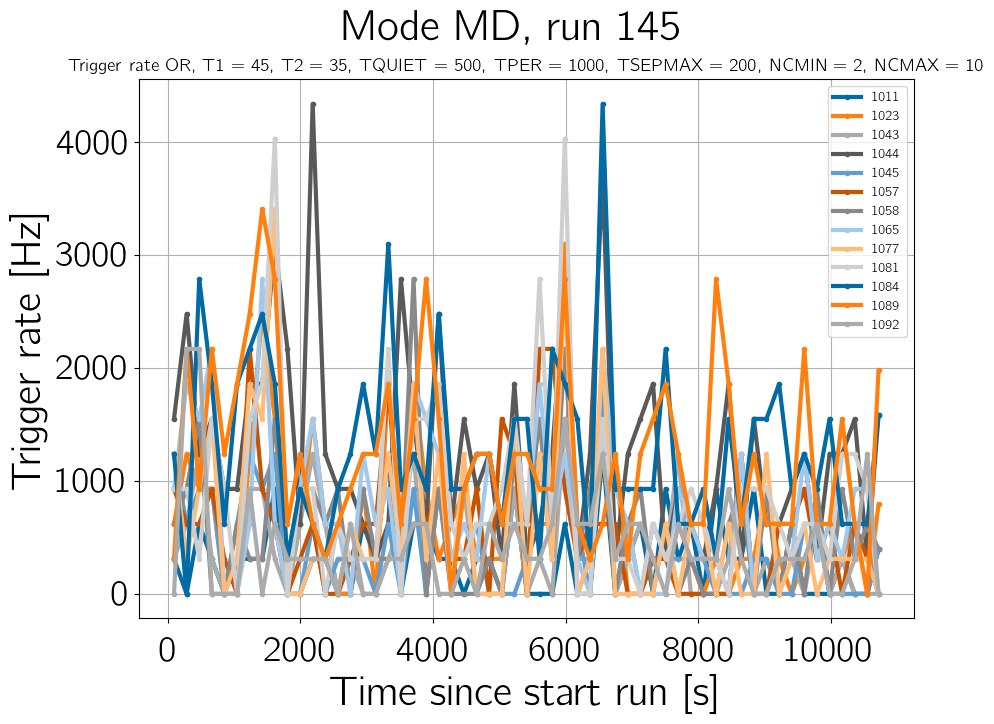

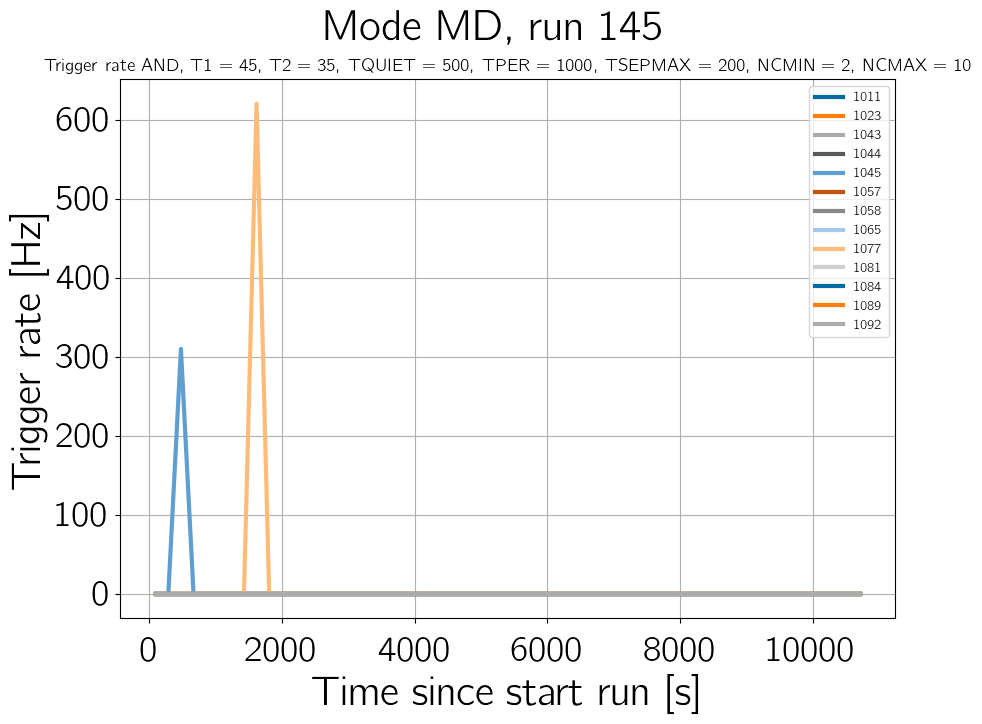

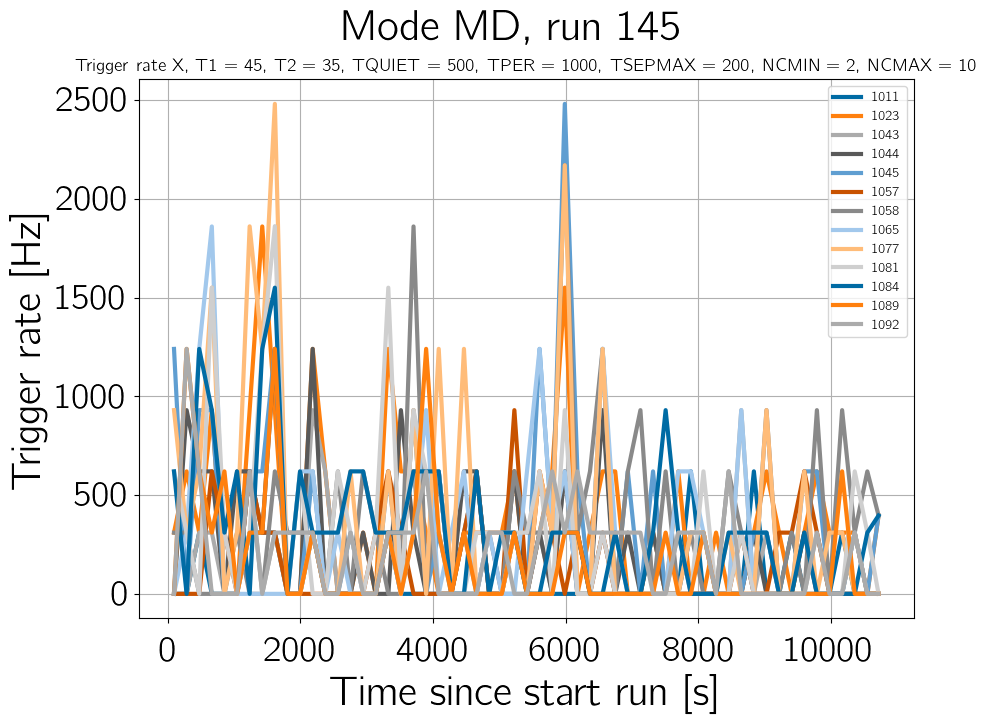

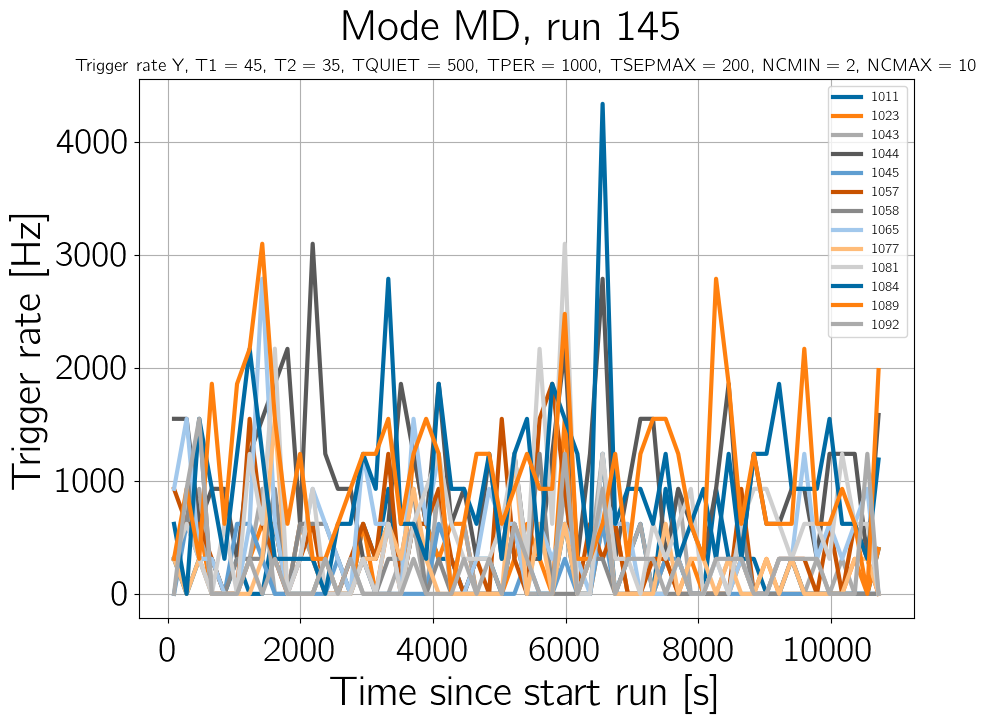

In [65]:
n_bins = len(paths_data_files_filtered)

time_since_start_run_bin_edges = np.zeros( (n_du,n_bins + 1) )
for i in range(n_du):
    for j in range(n_bins):
        time_since_start_run_bin_edges[i,j+1] = time_since_start_run_bin_edges[i,j] + t_bin_trigger_rate[i,j]

time_since_start_run_bin_centers = (time_since_start_run_bin_edges[...,1:] + time_since_start_run_bin_edges[...,:-1])/2
time_since_start_run_bin_widths  = (time_since_start_run_bin_edges[...,1:] - time_since_start_run_bin_edges[...,:-1])/2

fig, ax = plt.subplots()

for i, du_id in enumerate(du_ids_unique[:]):
    ax.plot(time_since_start_run_bin_centers[i],
            trigger_rate_OR[i],#*t_eff*1e-9,
            label=du_id,
            marker='o')
    
ax.set_xlabel('Time since start run [s]')
ax.set_ylabel('Trigger rate [Hz]')
ax.set_title(f'Trigger rate OR, '+PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE)
ax.legend(frameon=True,fontsize=10)

plt.show()


fig, ax = plt.subplots()

for i, du_id in enumerate(du_ids_unique[:]):
    ax.plot(time_since_start_run_bin_centers[i],
            trigger_rate_AND[i],
            label=du_id)
    
ax.set_xlabel('Time since start run [s]')
ax.set_ylabel('Trigger rate [Hz]')
ax.set_title(f'Trigger rate AND, '+PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE)
ax.legend(frameon=True,fontsize=10)

plt.show()


fig, ax = plt.subplots()

for i, du_id in enumerate(du_ids_unique[:]):
    ax.plot(time_since_start_run_bin_centers[i],
            trigger_rate_per_ch[i,...,0],
            label=du_id)
    
ax.set_xlabel('Time since start run [s]')
ax.set_ylabel('Trigger rate [Hz]')
ax.set_title(f'Trigger rate X, '+PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE)
ax.legend(frameon=True,fontsize=10)

plt.show()


fig, ax = plt.subplots()

for i, du_id in enumerate(du_ids_unique[:]):
    ax.plot(time_since_start_run_bin_centers[i],
            trigger_rate_per_ch[i,...,1],
            label=du_id)
    
ax.set_xlabel('Time since start run [s]')
ax.set_ylabel('Trigger rate [Hz]')
ax.set_title(f'Trigger rate Y, '+PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE)
ax.legend(frameon=True,fontsize=10)

plt.show()

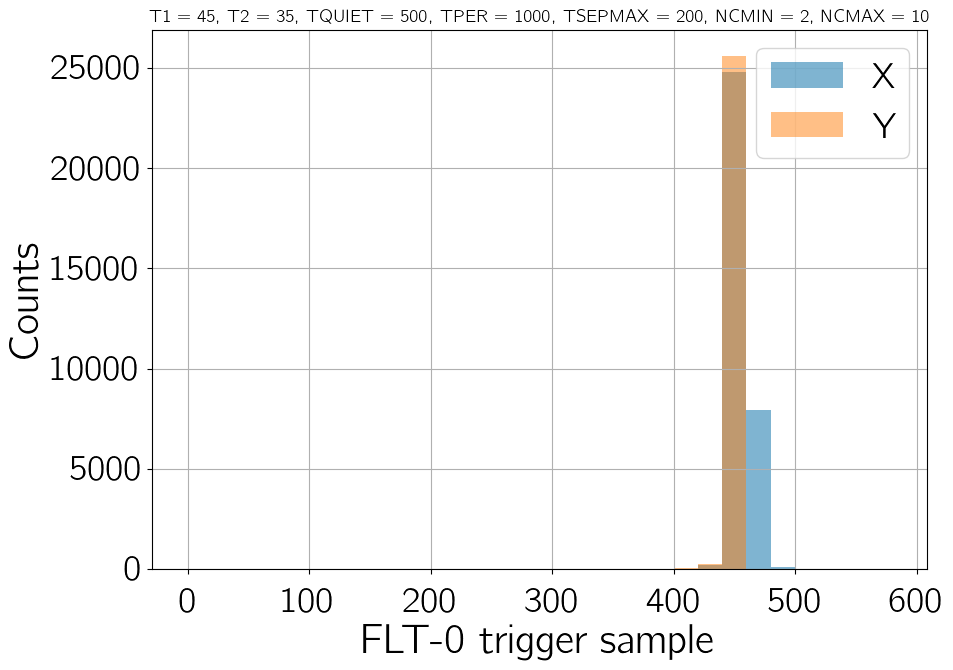

In [8]:
bins = np.arange(0,600,20)

fig, ax = plt.subplots()

for ch in channels_flt0:
    ax.hist( FLT0_first_T1_idcs[:,ch], bins=bins,alpha=.5,label=channel_pol[ch] )

ax.set_xlabel('FLT-0 trigger sample')
ax.set_ylabel('Counts')

ax.set_title(PLOT_TITLE,fontsize=13)

ax.legend(frameon=True)

plt.show()

## Look at SNR

In [10]:
rms_traces_filtered = np.sqrt( np.mean( traces_filtered[...,samples_from_edge:]**2,axis=2 ) )
max_traces_filtered = np.max( traces_filtered[...,samples_from_edge:],axis=2 )

rms_traces_trigger  = rms_traces_filtered[FLT0_flags] # can do this since there are pretty much no AND triggers; or basically we mix all X and Y
max_traces_trigger  = max_traces_filtered[FLT0_flags]

snr = max_traces_trigger/rms_traces_trigger

In [11]:
traces_filtered.shape

(42261, 3, 1024)

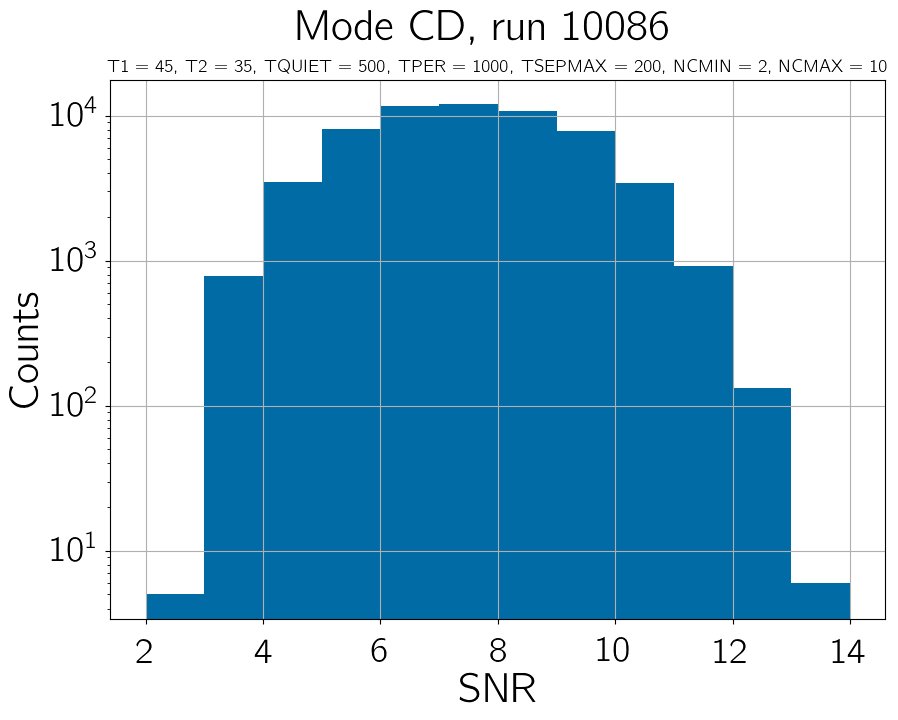

In [13]:
fig, ax = plt.subplots()

ax.hist(snr,bins=np.arange(2,15,1.))

ax.set_xlabel('SNR')
ax.set_ylabel('Counts')

ax.set_title(PLOT_TITLE,fontsize=13)
plt.suptitle(PLOT_SUPTITLE)

ax.set_yscale('log')

plt.show()

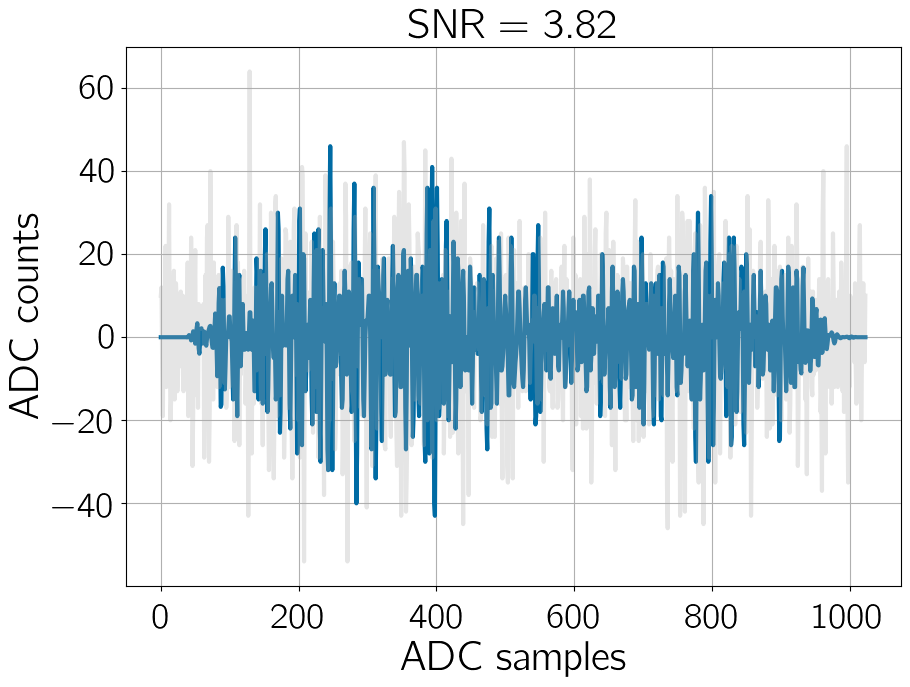

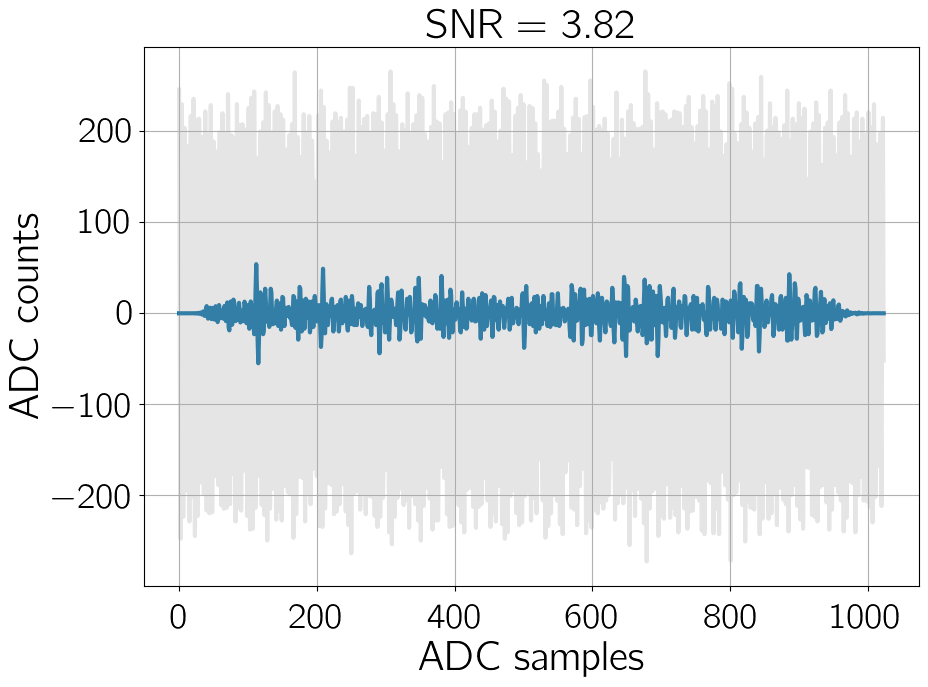

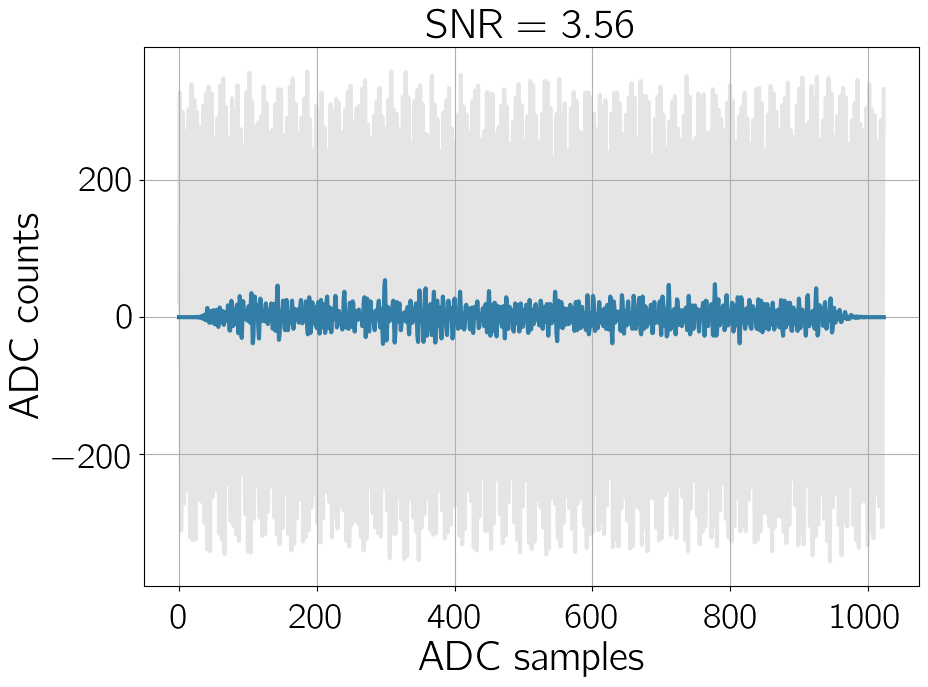

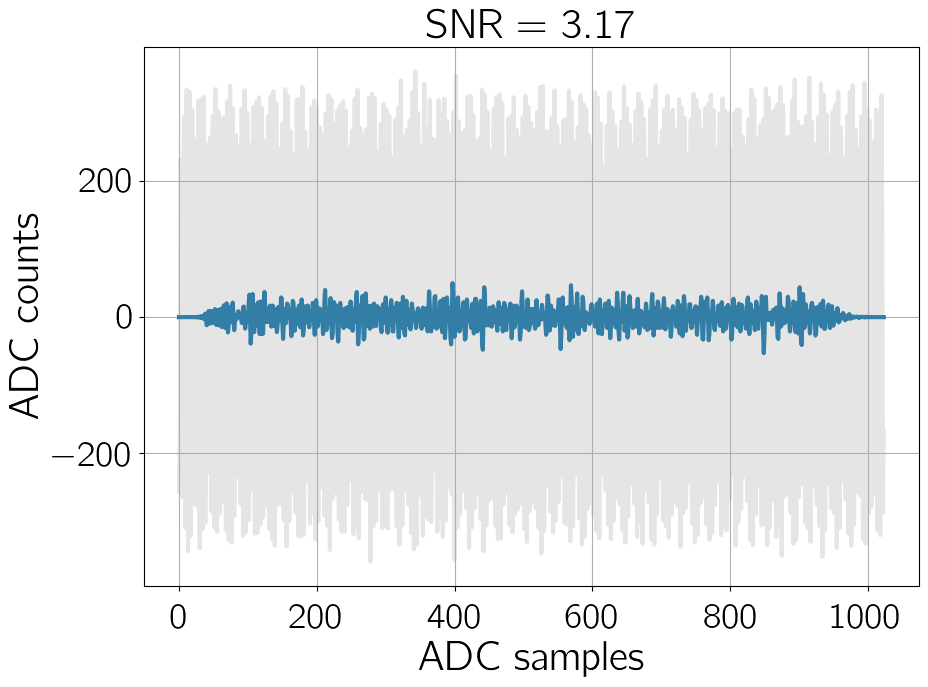

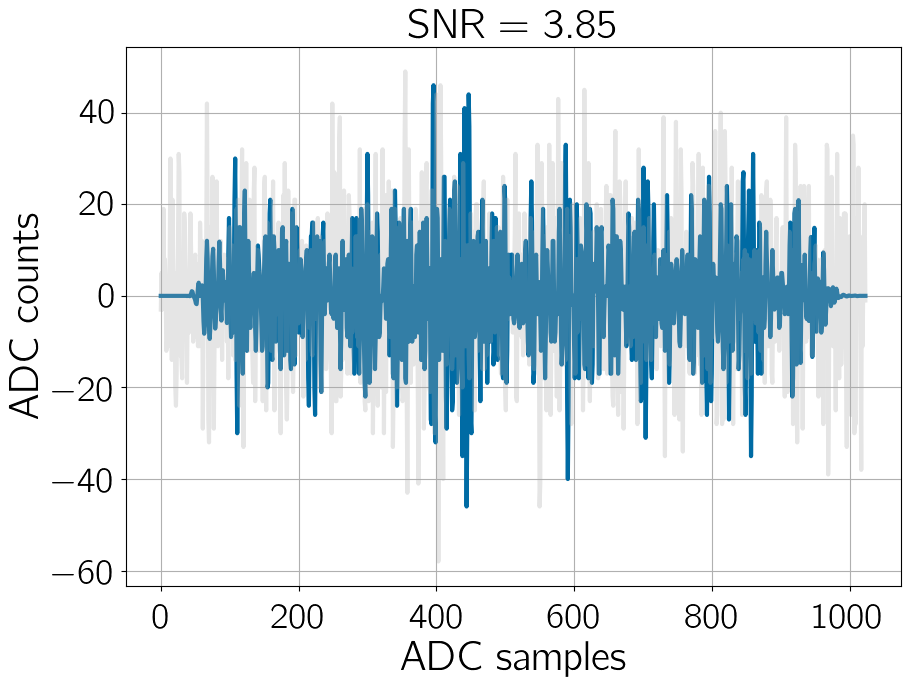

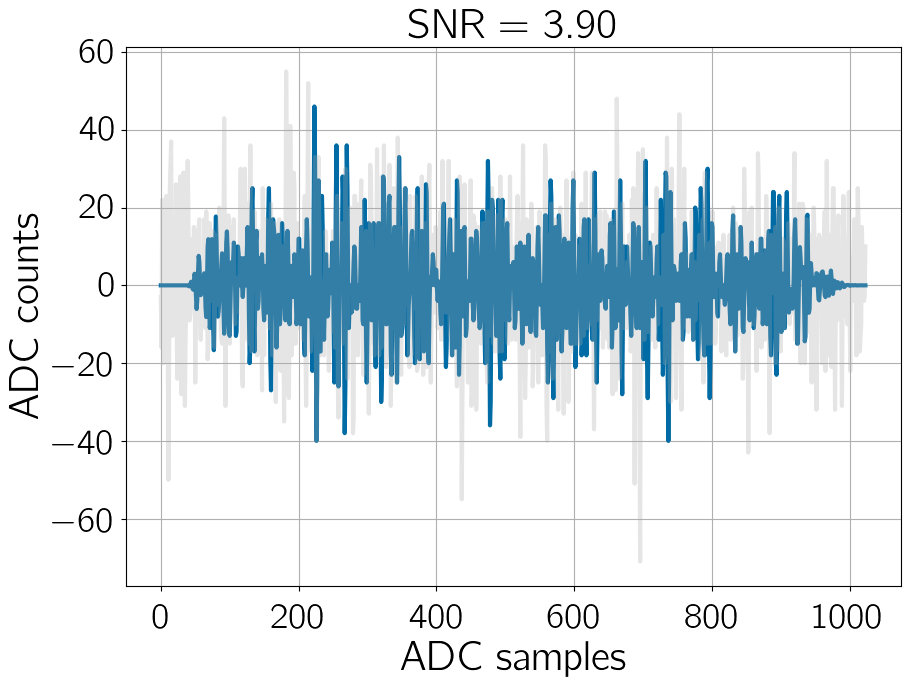

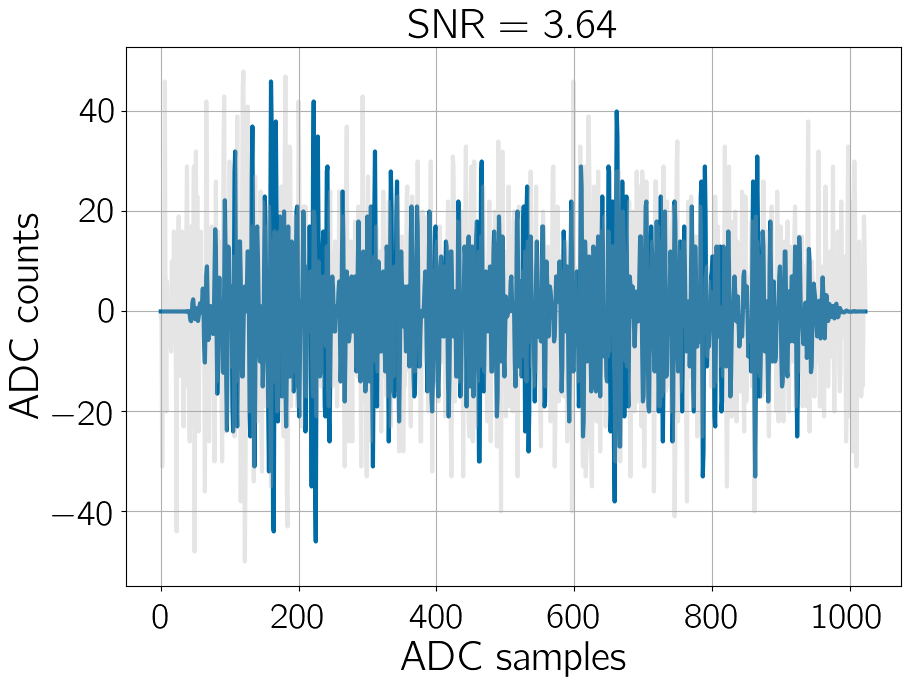

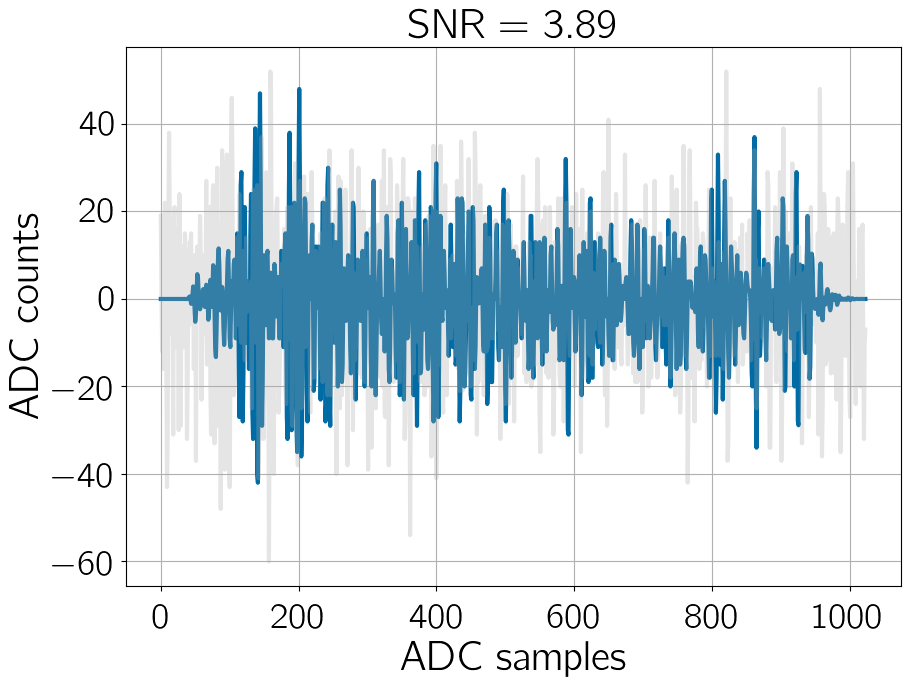

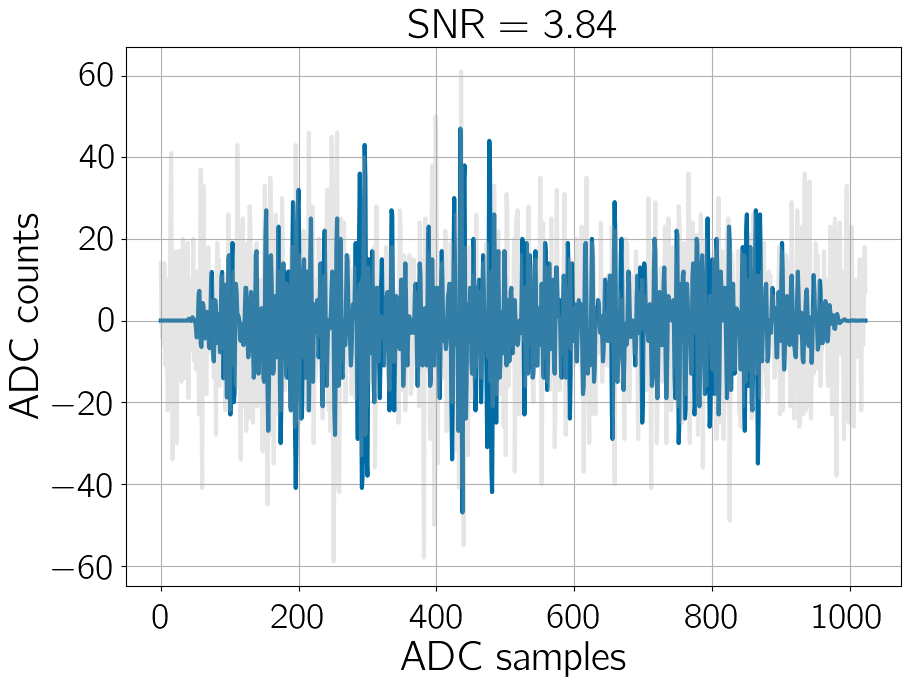

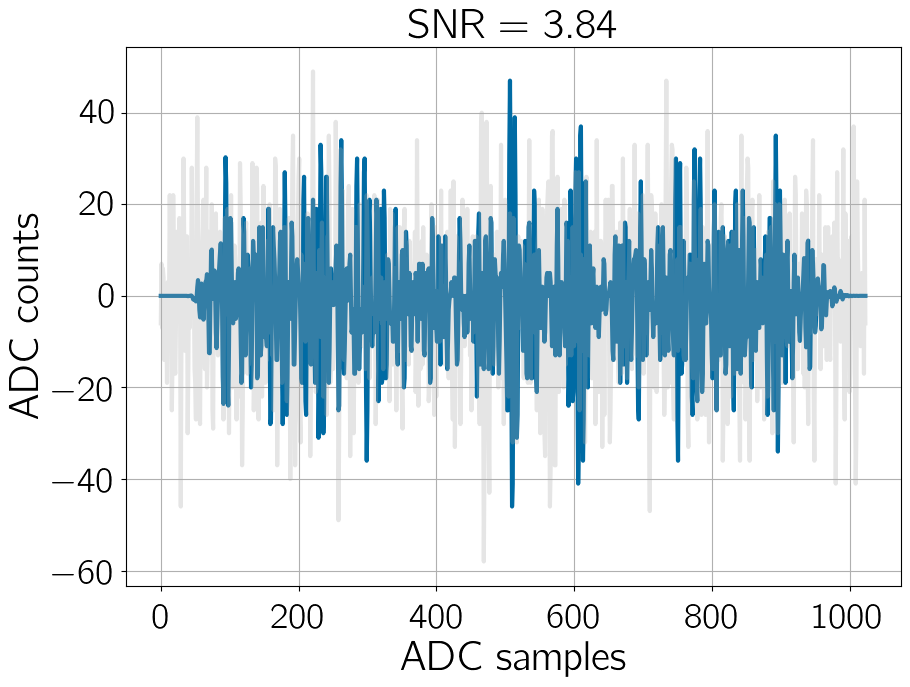

In [70]:
traces_trigger = traces_filtered[FLT0_flags]
traces_trigger_raw = traces_raw[FLT0_flags]

plt_idx = 0
for i, _snr in enumerate(snr):
    if _snr > 3 and _snr < 4 and plt_idx < 10:
        plt.plot(traces_trigger[i])
        plt.plot(traces_trigger_raw[i],color=PLOT_COLORS[2],alpha=.3)
        plt.xlabel('ADC samples')
        plt.ylabel('ADC counts')
        plt.title(f'SNR = {_snr:.2f}')
        plt.show()
        plt_idx += 1

## Plot some traces

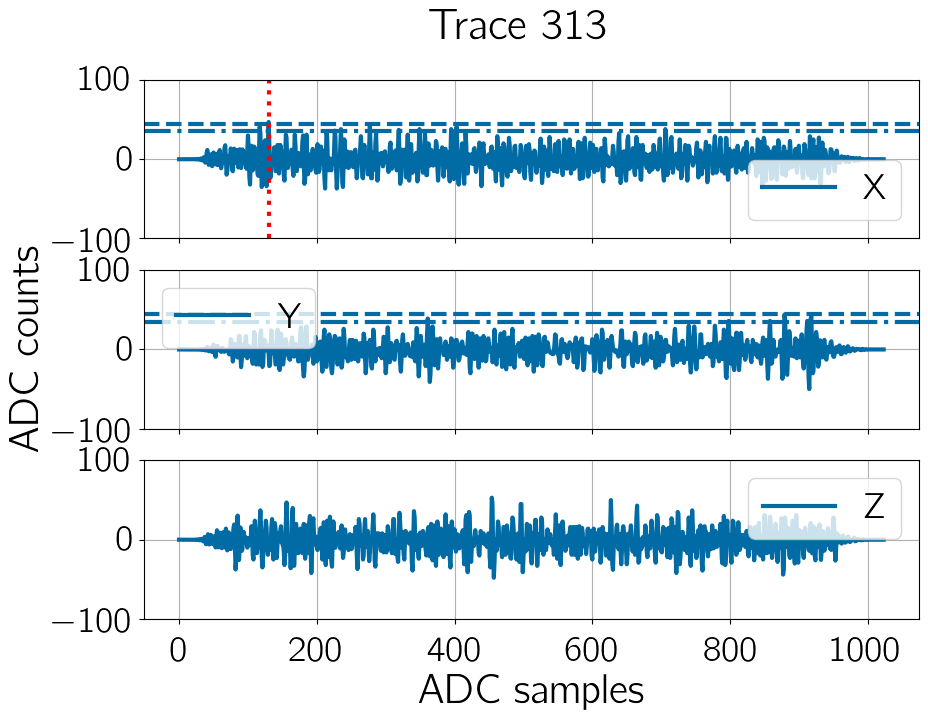

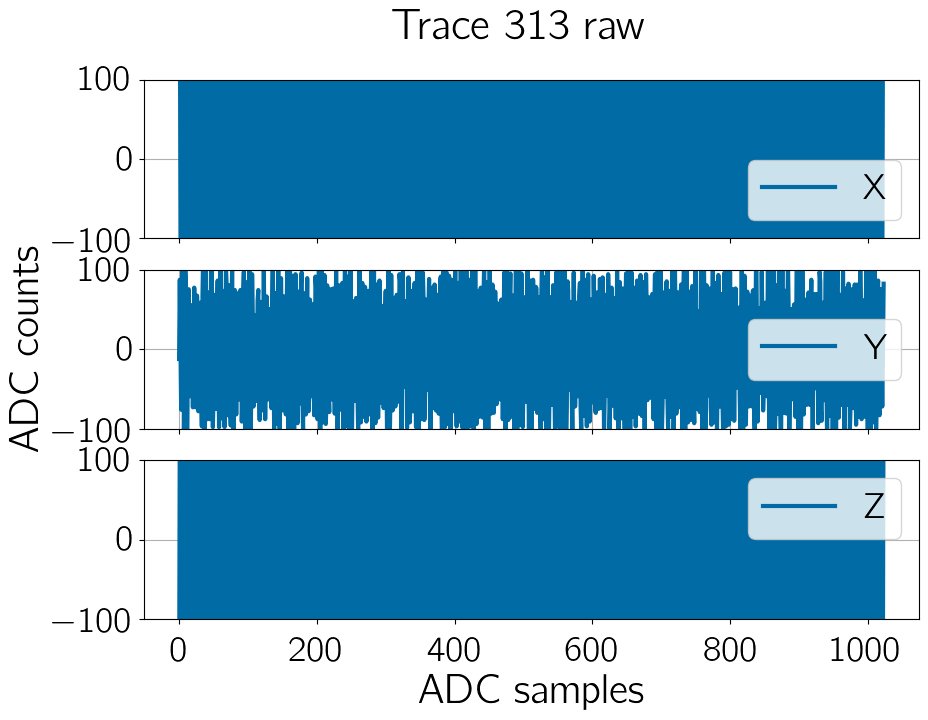

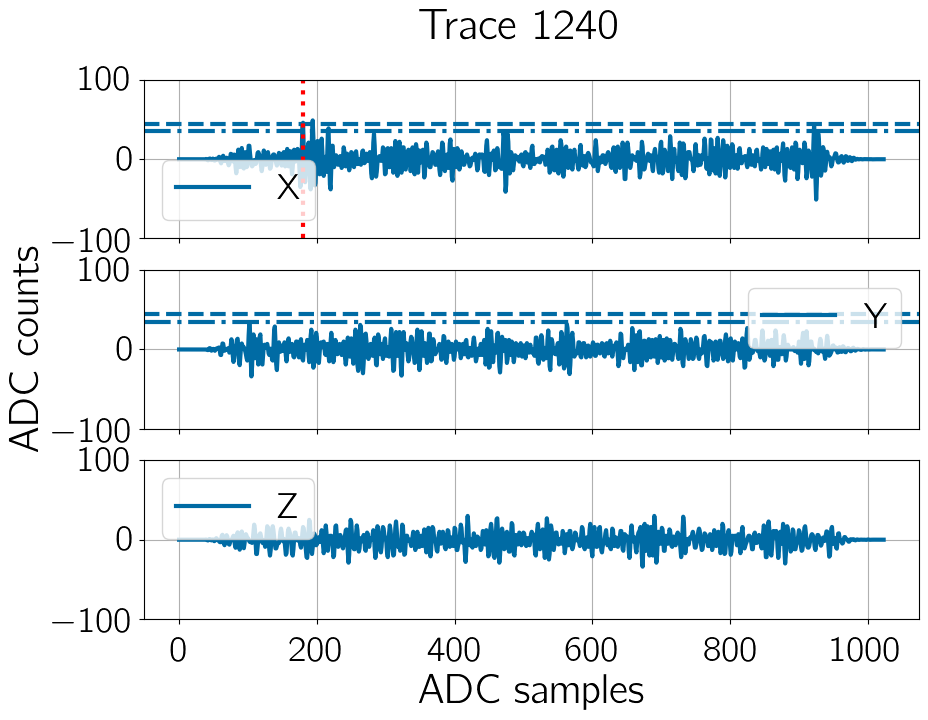

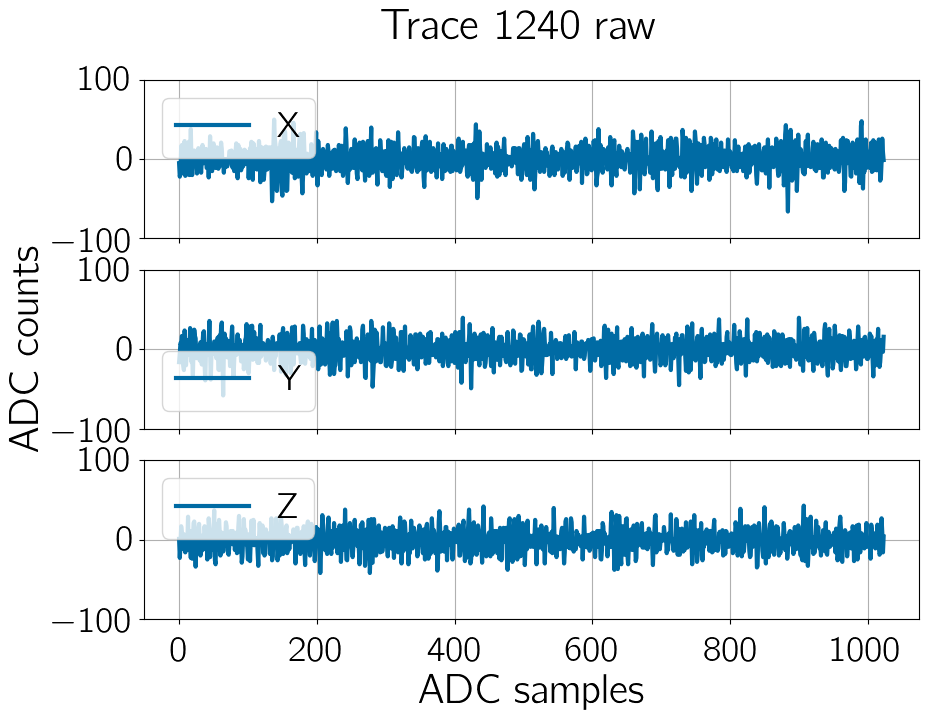

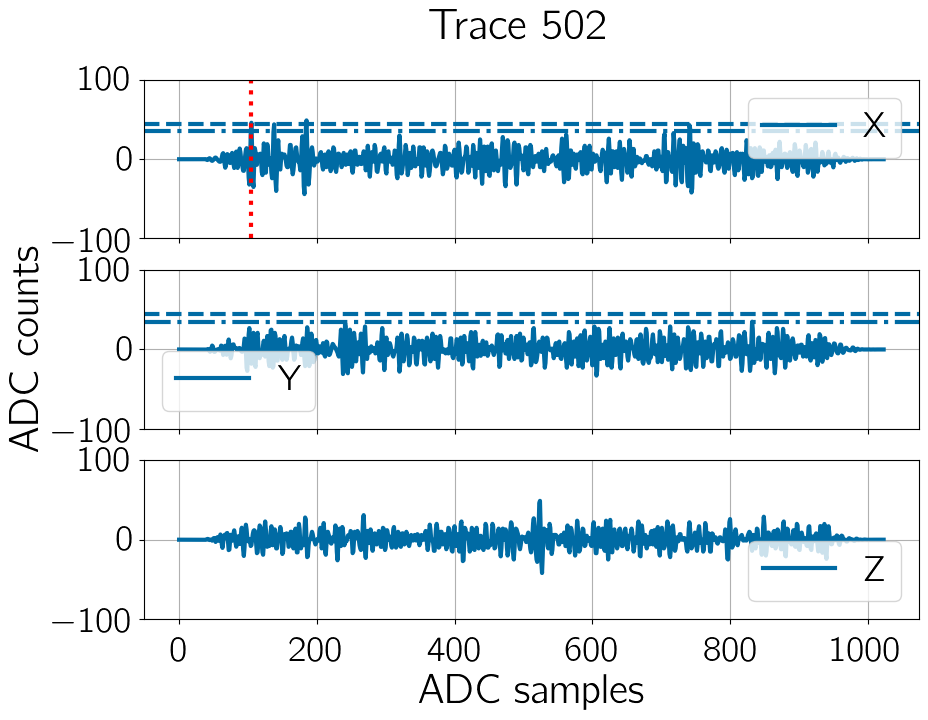

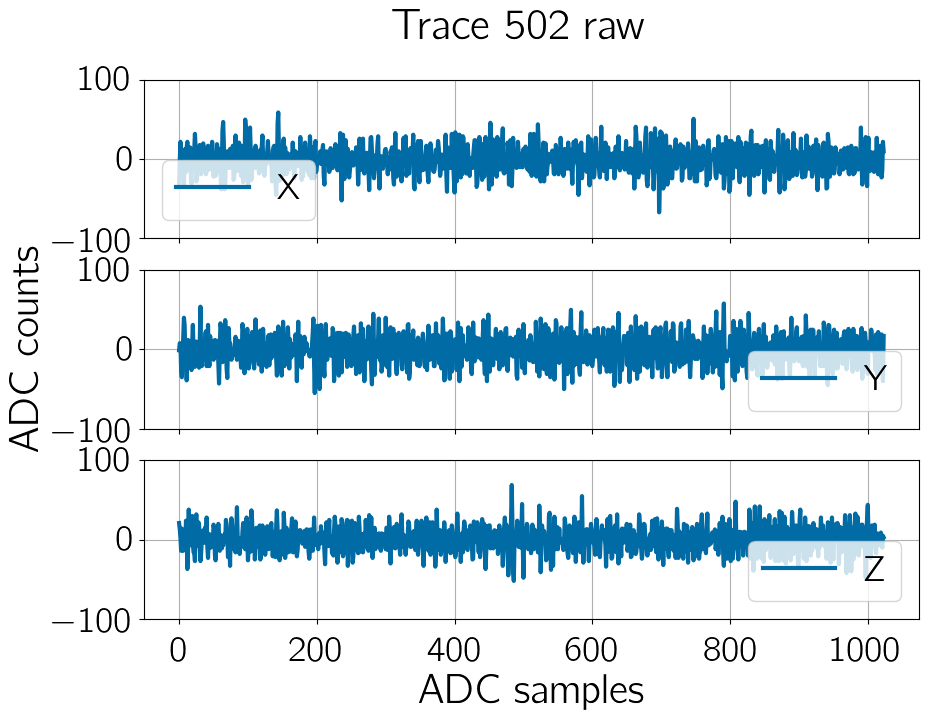

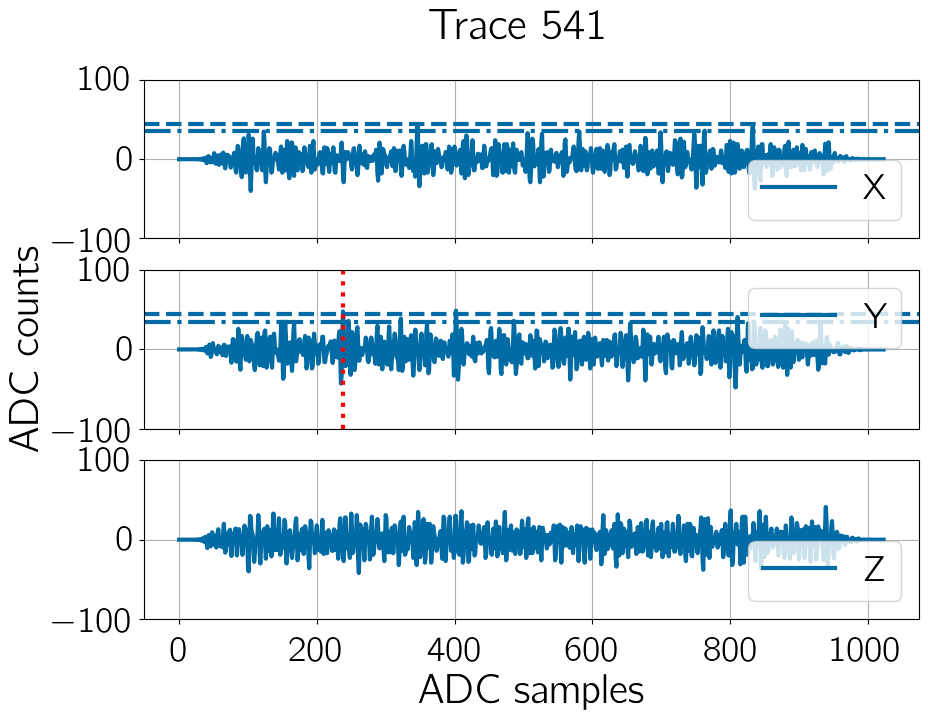

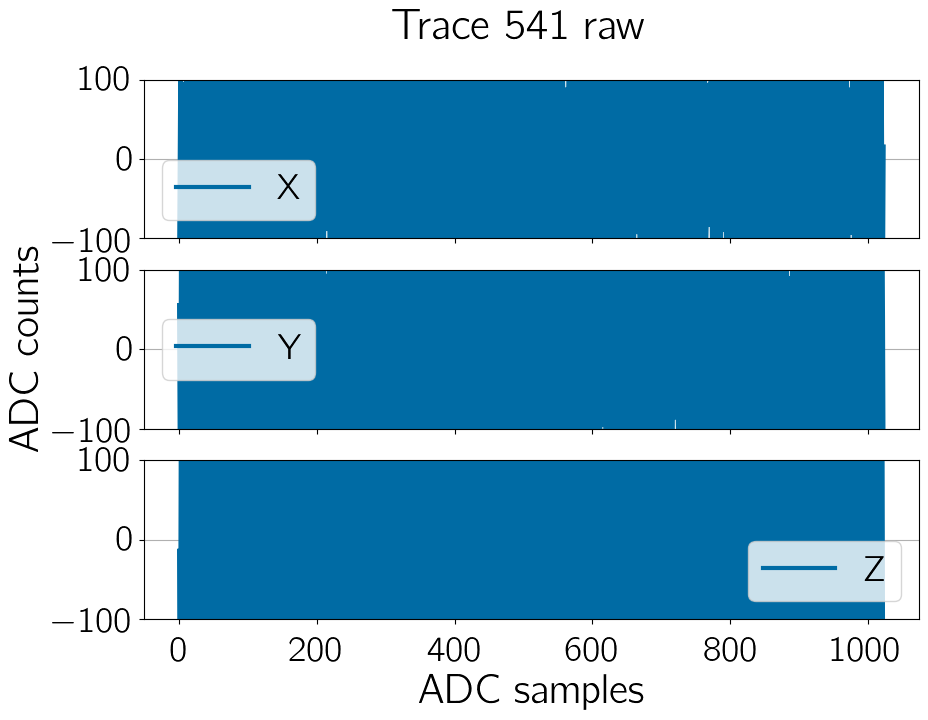

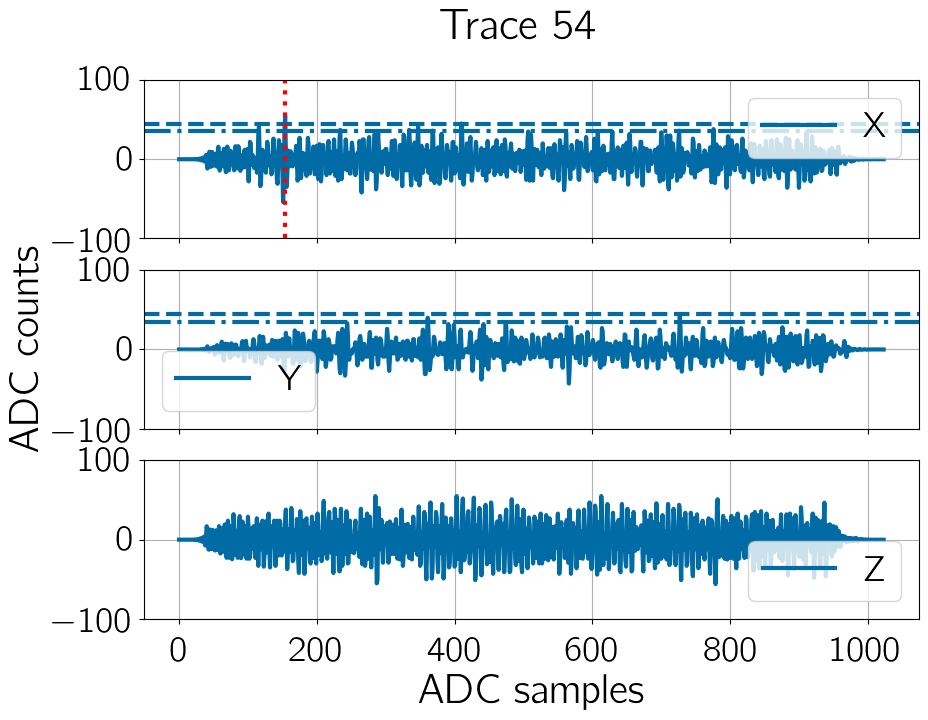

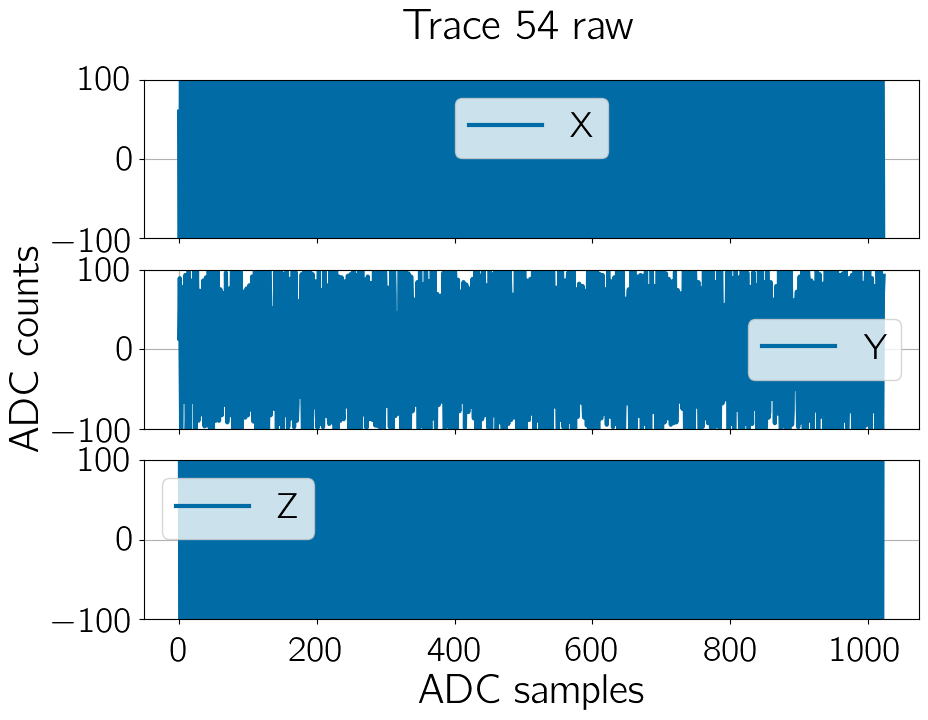

In [71]:
idcs = np.random.randint(0,high=len(traces_filtered),size=5)

for i in idcs:
    fig, ax = plt.subplots(N_CHANNELS,1,sharex=True)

    for ch in range(N_CHANNELS):
        ax[ch].plot(traces_filtered[i,ch],label=f'{channel_pol[ch]}')
        ax[ch].legend(frameon=True)
        ax[ch].set_ylim([-100,100])
        if ch in channels_flt0:
            ax[ch].axhline(TH1,ls='--')
            ax[ch].axhline(TH2,ls='-.')
        if FLT0_first_T1_idcs[i,ch] >= 0:
            ax[ch].axvline(FLT0_first_T1_idcs[i,ch],ls=':',color='r')

    ax[2].set_xlabel('ADC samples')
    ax[1].set_ylabel('ADC counts')

    plt.suptitle(f'Trace {i}',va='top')

    plt.show()


    fig, ax = plt.subplots(N_CHANNELS,1,sharex=True)

    for ch in range(N_CHANNELS):
        ax[ch].plot(traces_raw[i,ch],label=f'{channel_pol[ch]}')
        ax[ch].legend(frameon=True)
        ax[ch].set_ylim([-100,100])

    ax[2].set_xlabel('ADC samples')
    ax[1].set_ylabel('ADC counts')

    plt.suptitle(f'Trace {i} raw',va='top')

    plt.show()

In [8]:
FLT0_first_T1_idcs

array([[145,  -1,  -1],
       [446,  -1,  -1],
       [176,  -1,  -1],
       ...,
       [ -1, 125,  -1],
       [137,  -1,  -1],
       [254,  -1,  -1]])